# MP Plus data train

加入物理特征进行训练
**物理特征包括：**
nsites、crystal_system、space_group、volume、density、
density_atomic、efermi、energy_per_atom、formation_energy_per_atom、is_gap_direct、is_oxide


In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'XGBoost'

In [2]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts'

In [ ]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_plus_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_plus_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']

dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']


In [6]:
dft_train.shape, dft_test.shape

((4412, 145), (1108, 145))

## Model Train

### DFT Model

In [7]:
fig_path = os.path.join(current_path, 'figures', 'MP_plus')
os.makedirs(fig_path, exist_ok=True)

####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.0s
Model training completed!
[Train_error] Evaluating DFT XGBoost on DFT train set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\MP_plus\train_error.png


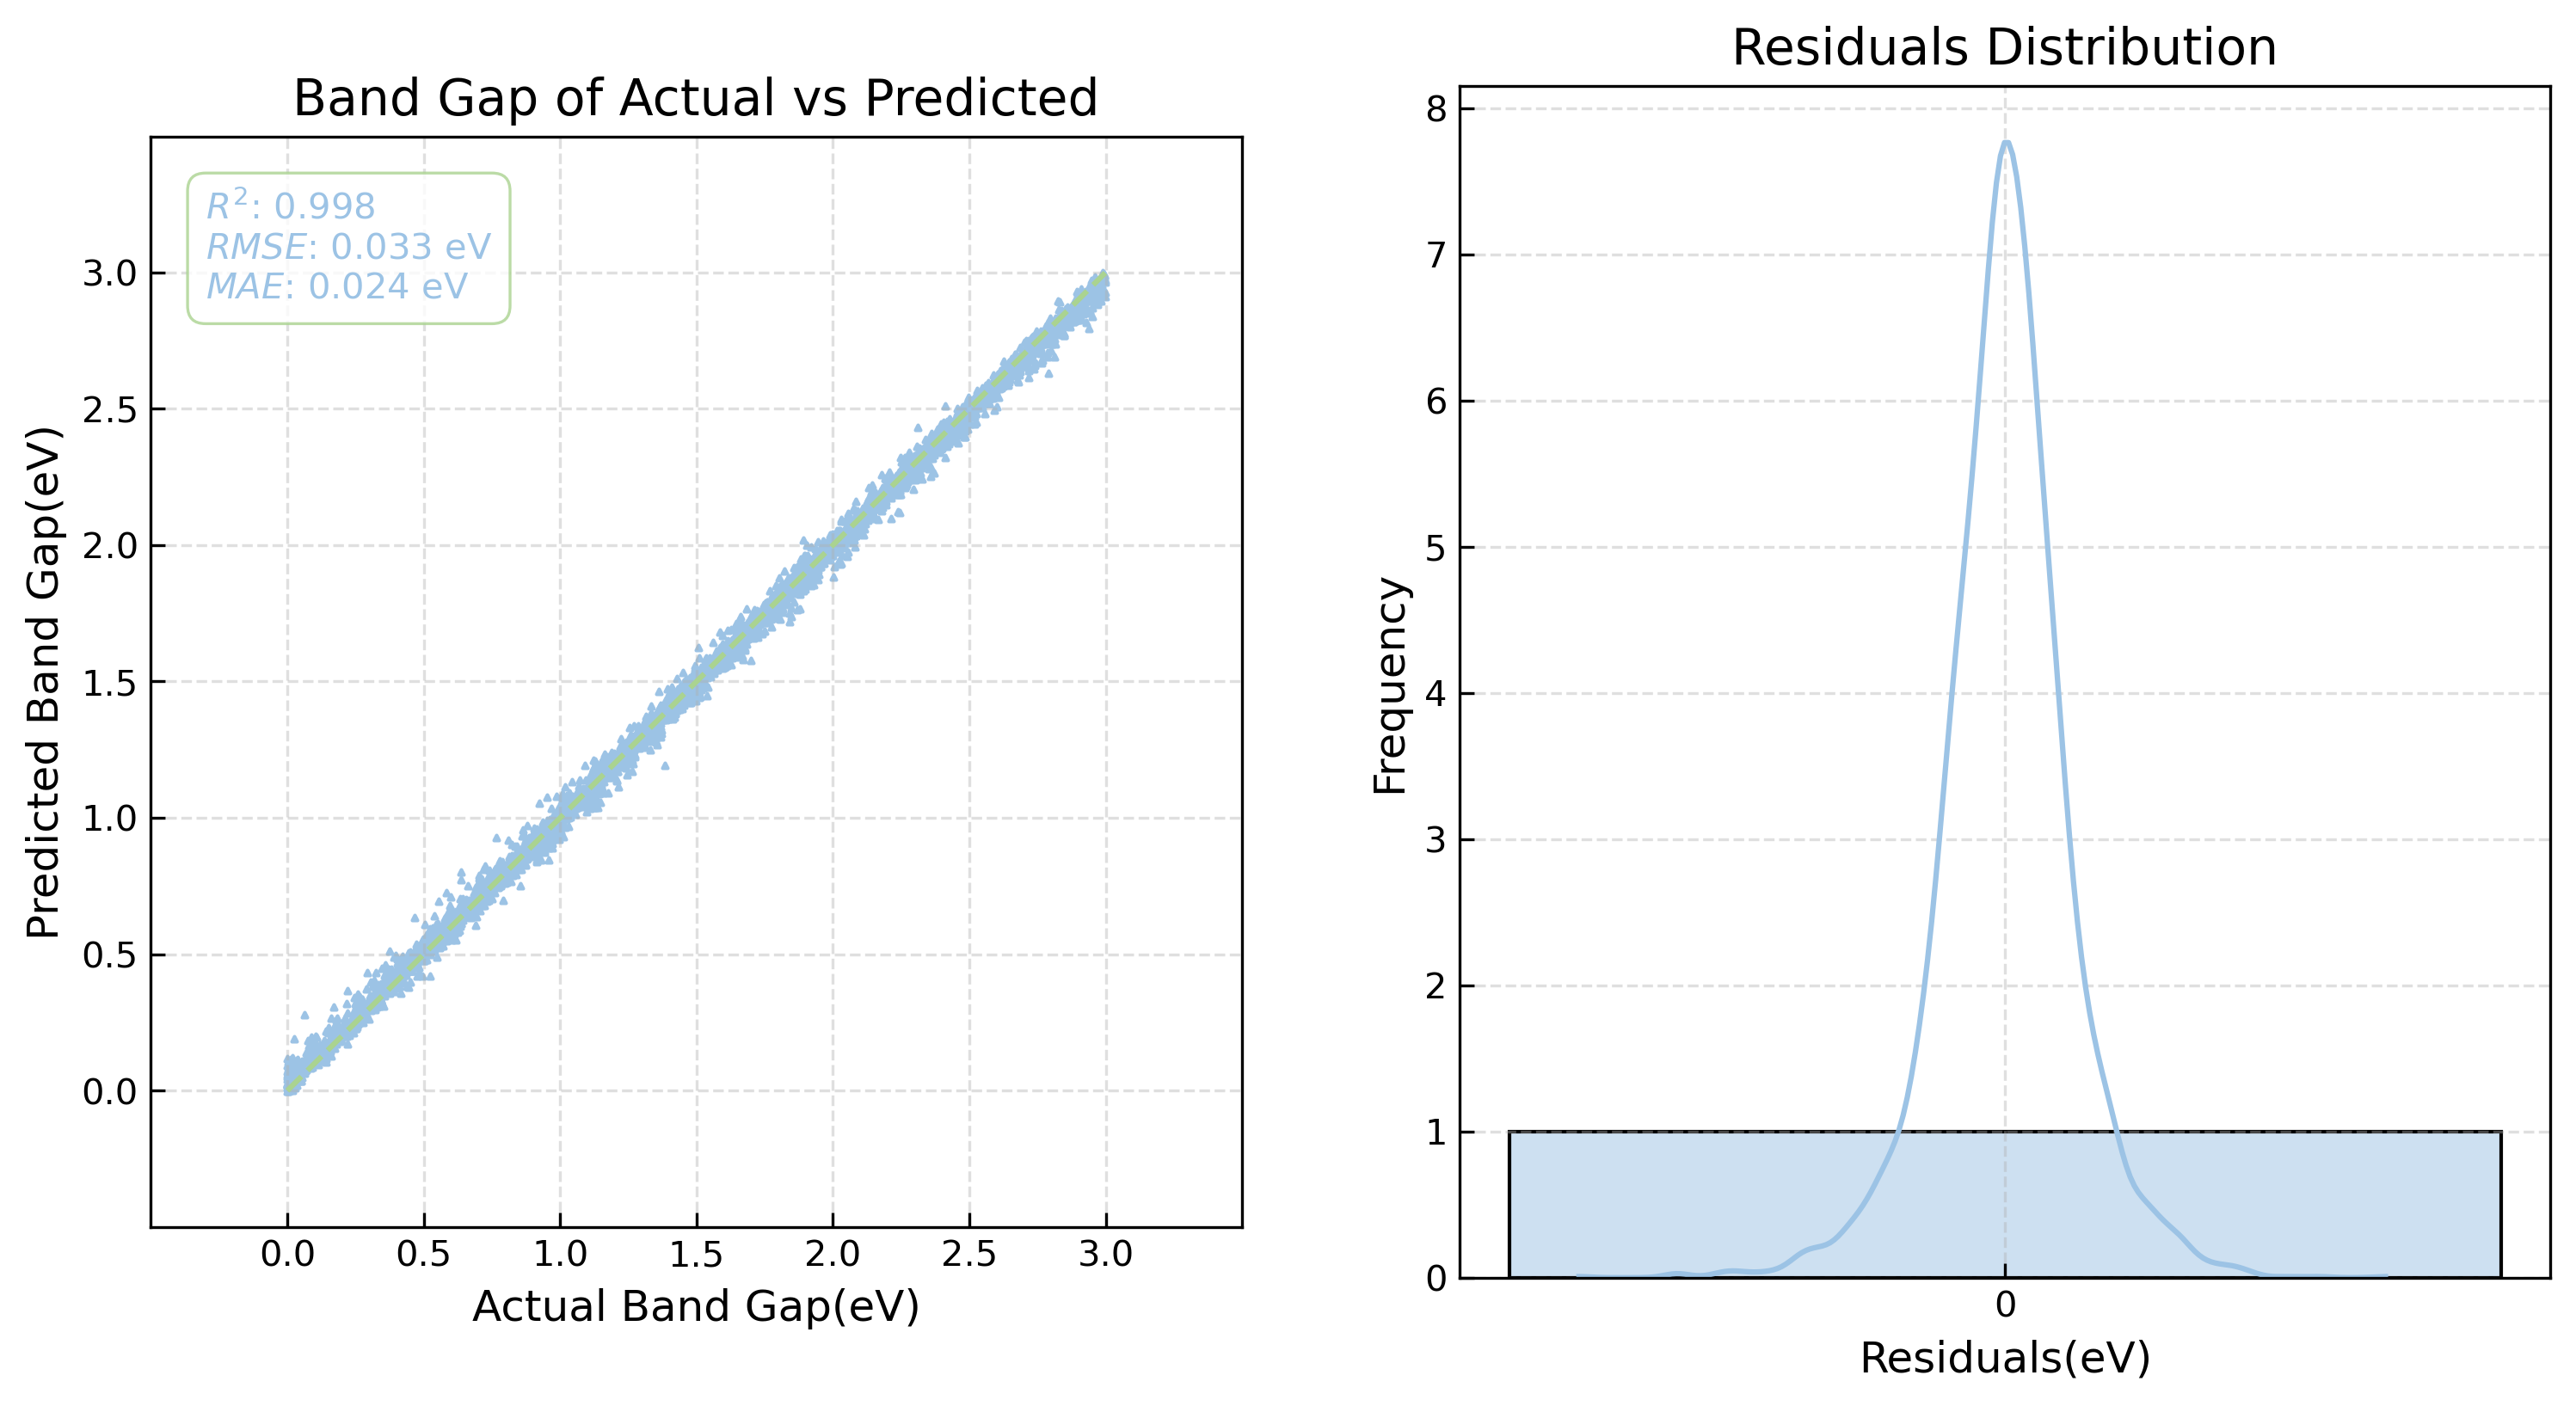


Model Evaluation Results:
Test set size: 4412
Test set: R²: 0.9985 RMSE: 0.0330 MAE: 0.0239 MAPE: 84.8860%
[Test DFT -> DFT] Evaluating DFT XGBoost on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\MP_plus\test_error.png


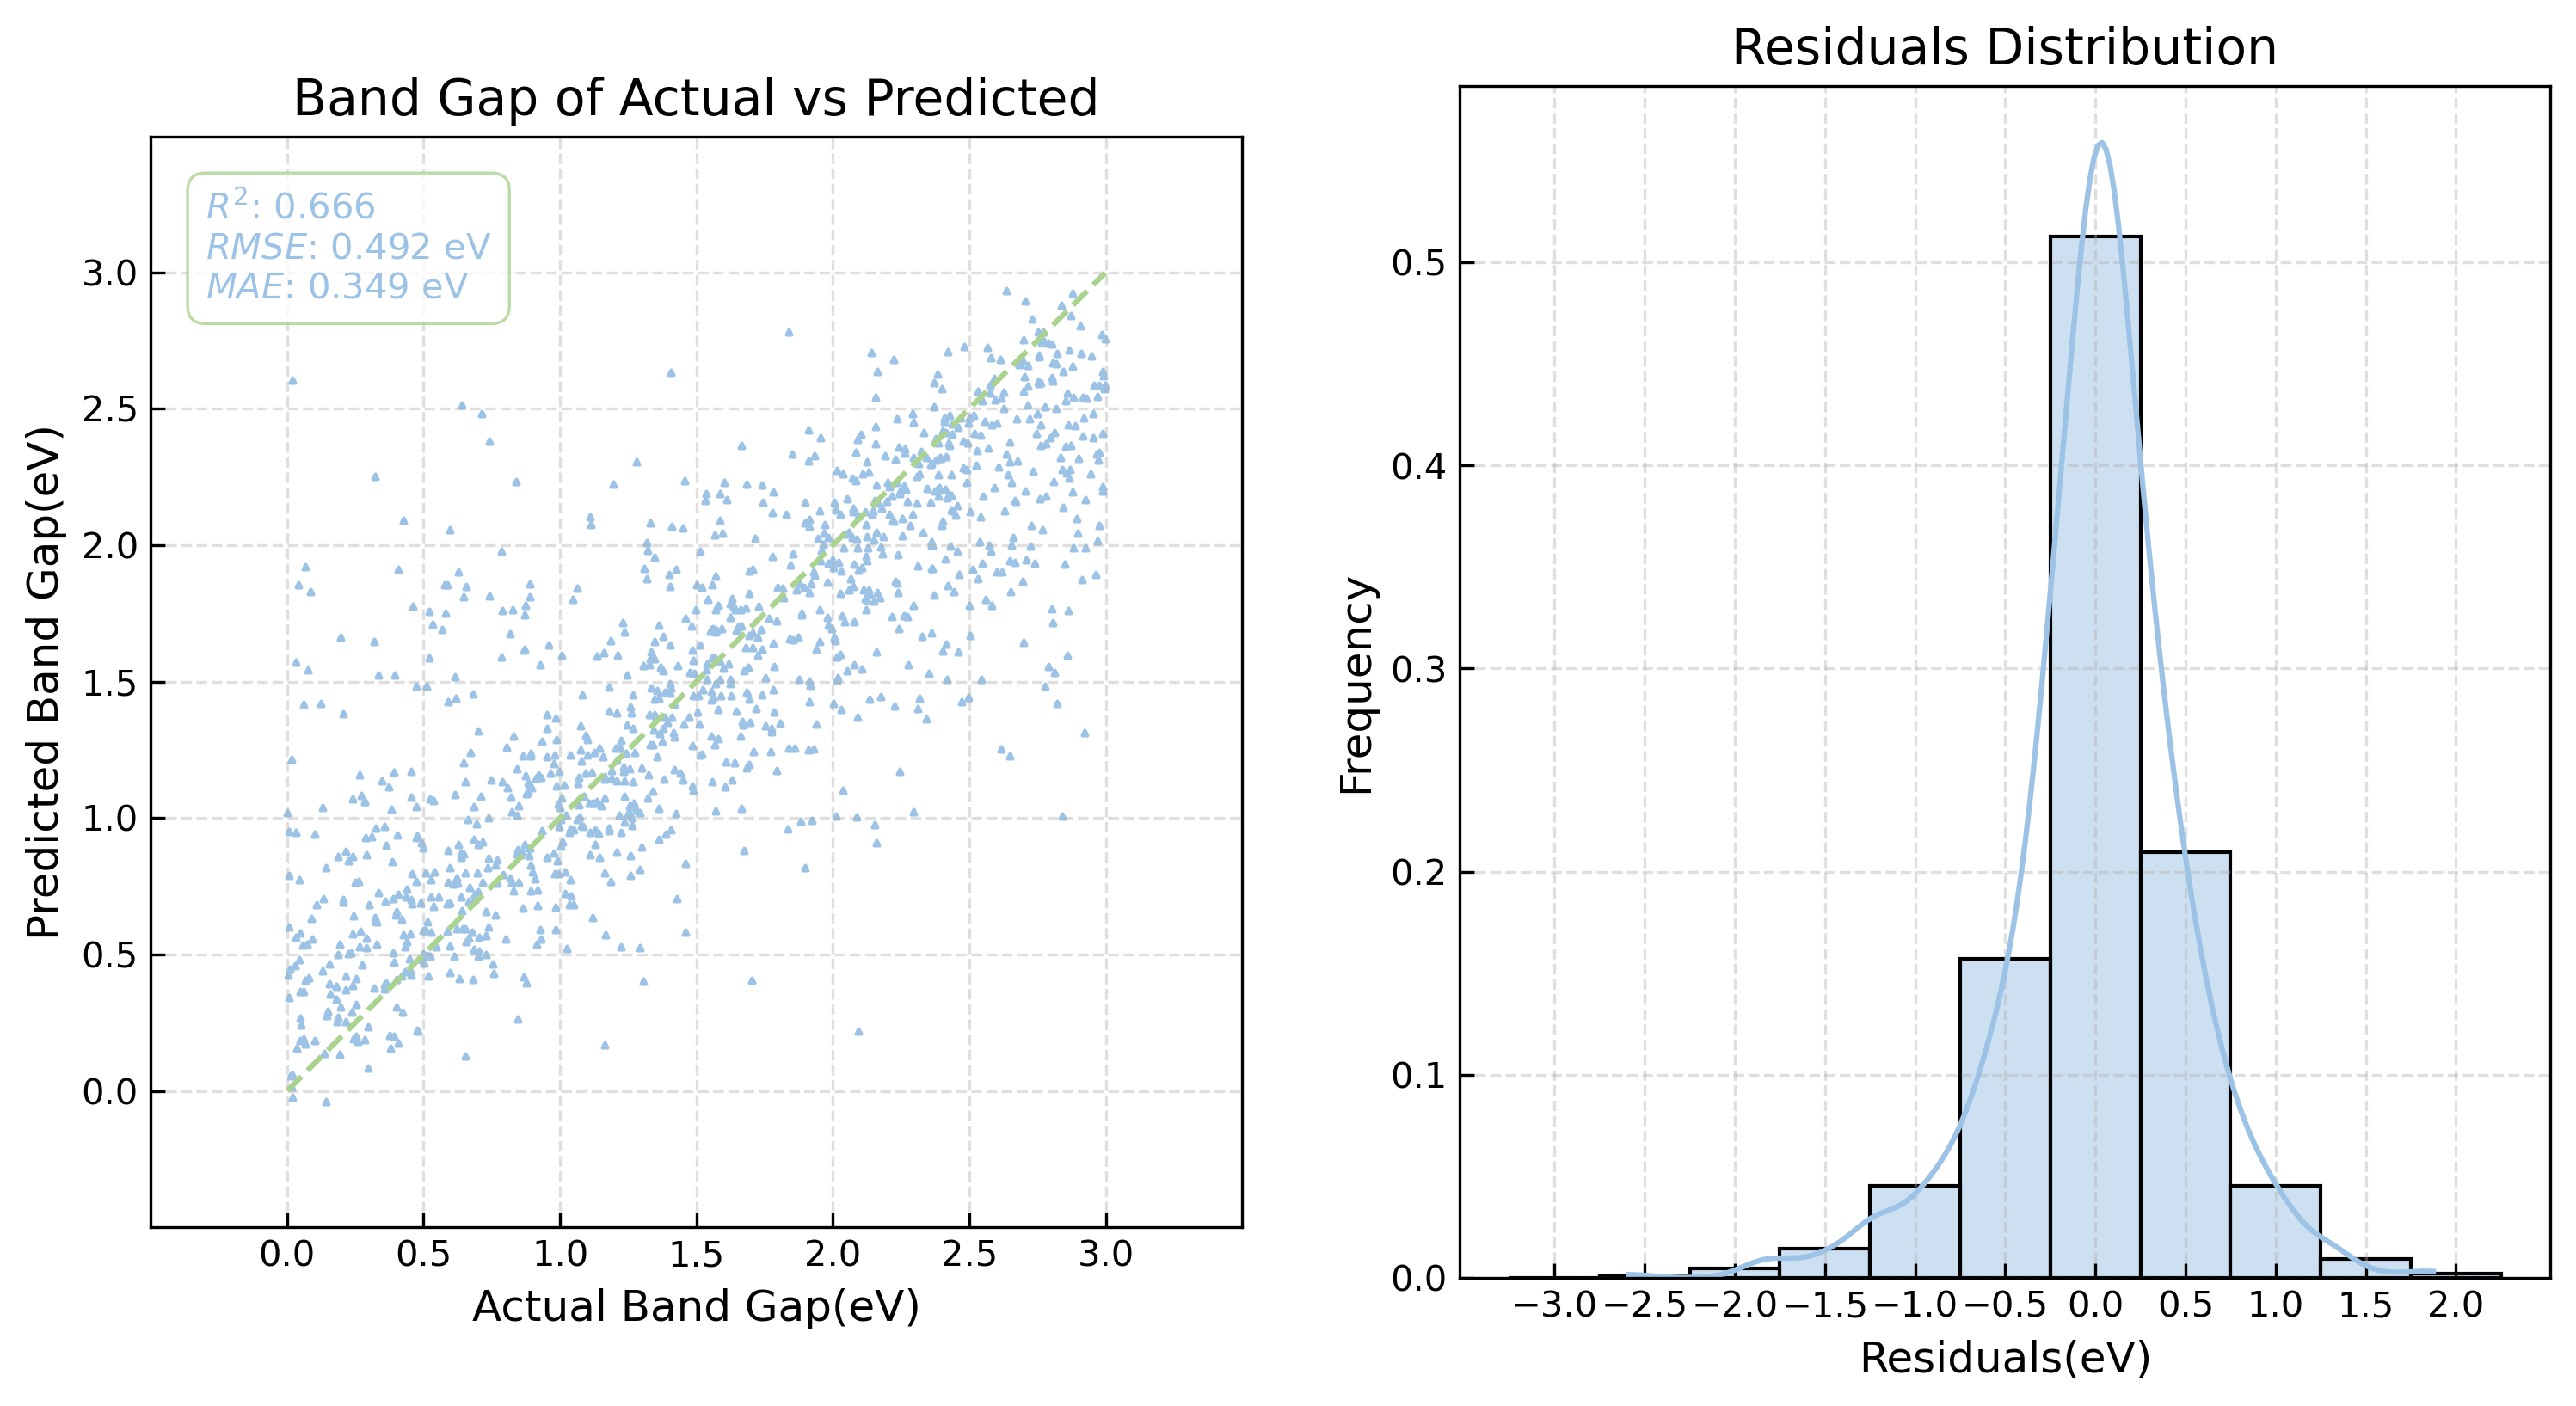


Model Evaluation Results:
Test set size: 1108
Test set: R²: 0.6663 RMSE: 0.4918 MAE: 0.3493 MAPE: 220.7468%


In [8]:
xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y, fig_path=os.path.join(fig_path, 'train_error.png'))
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y, fig_path=os.path.join(fig_path, 'test_error.png'))
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\MP_plus\feature_importance.png


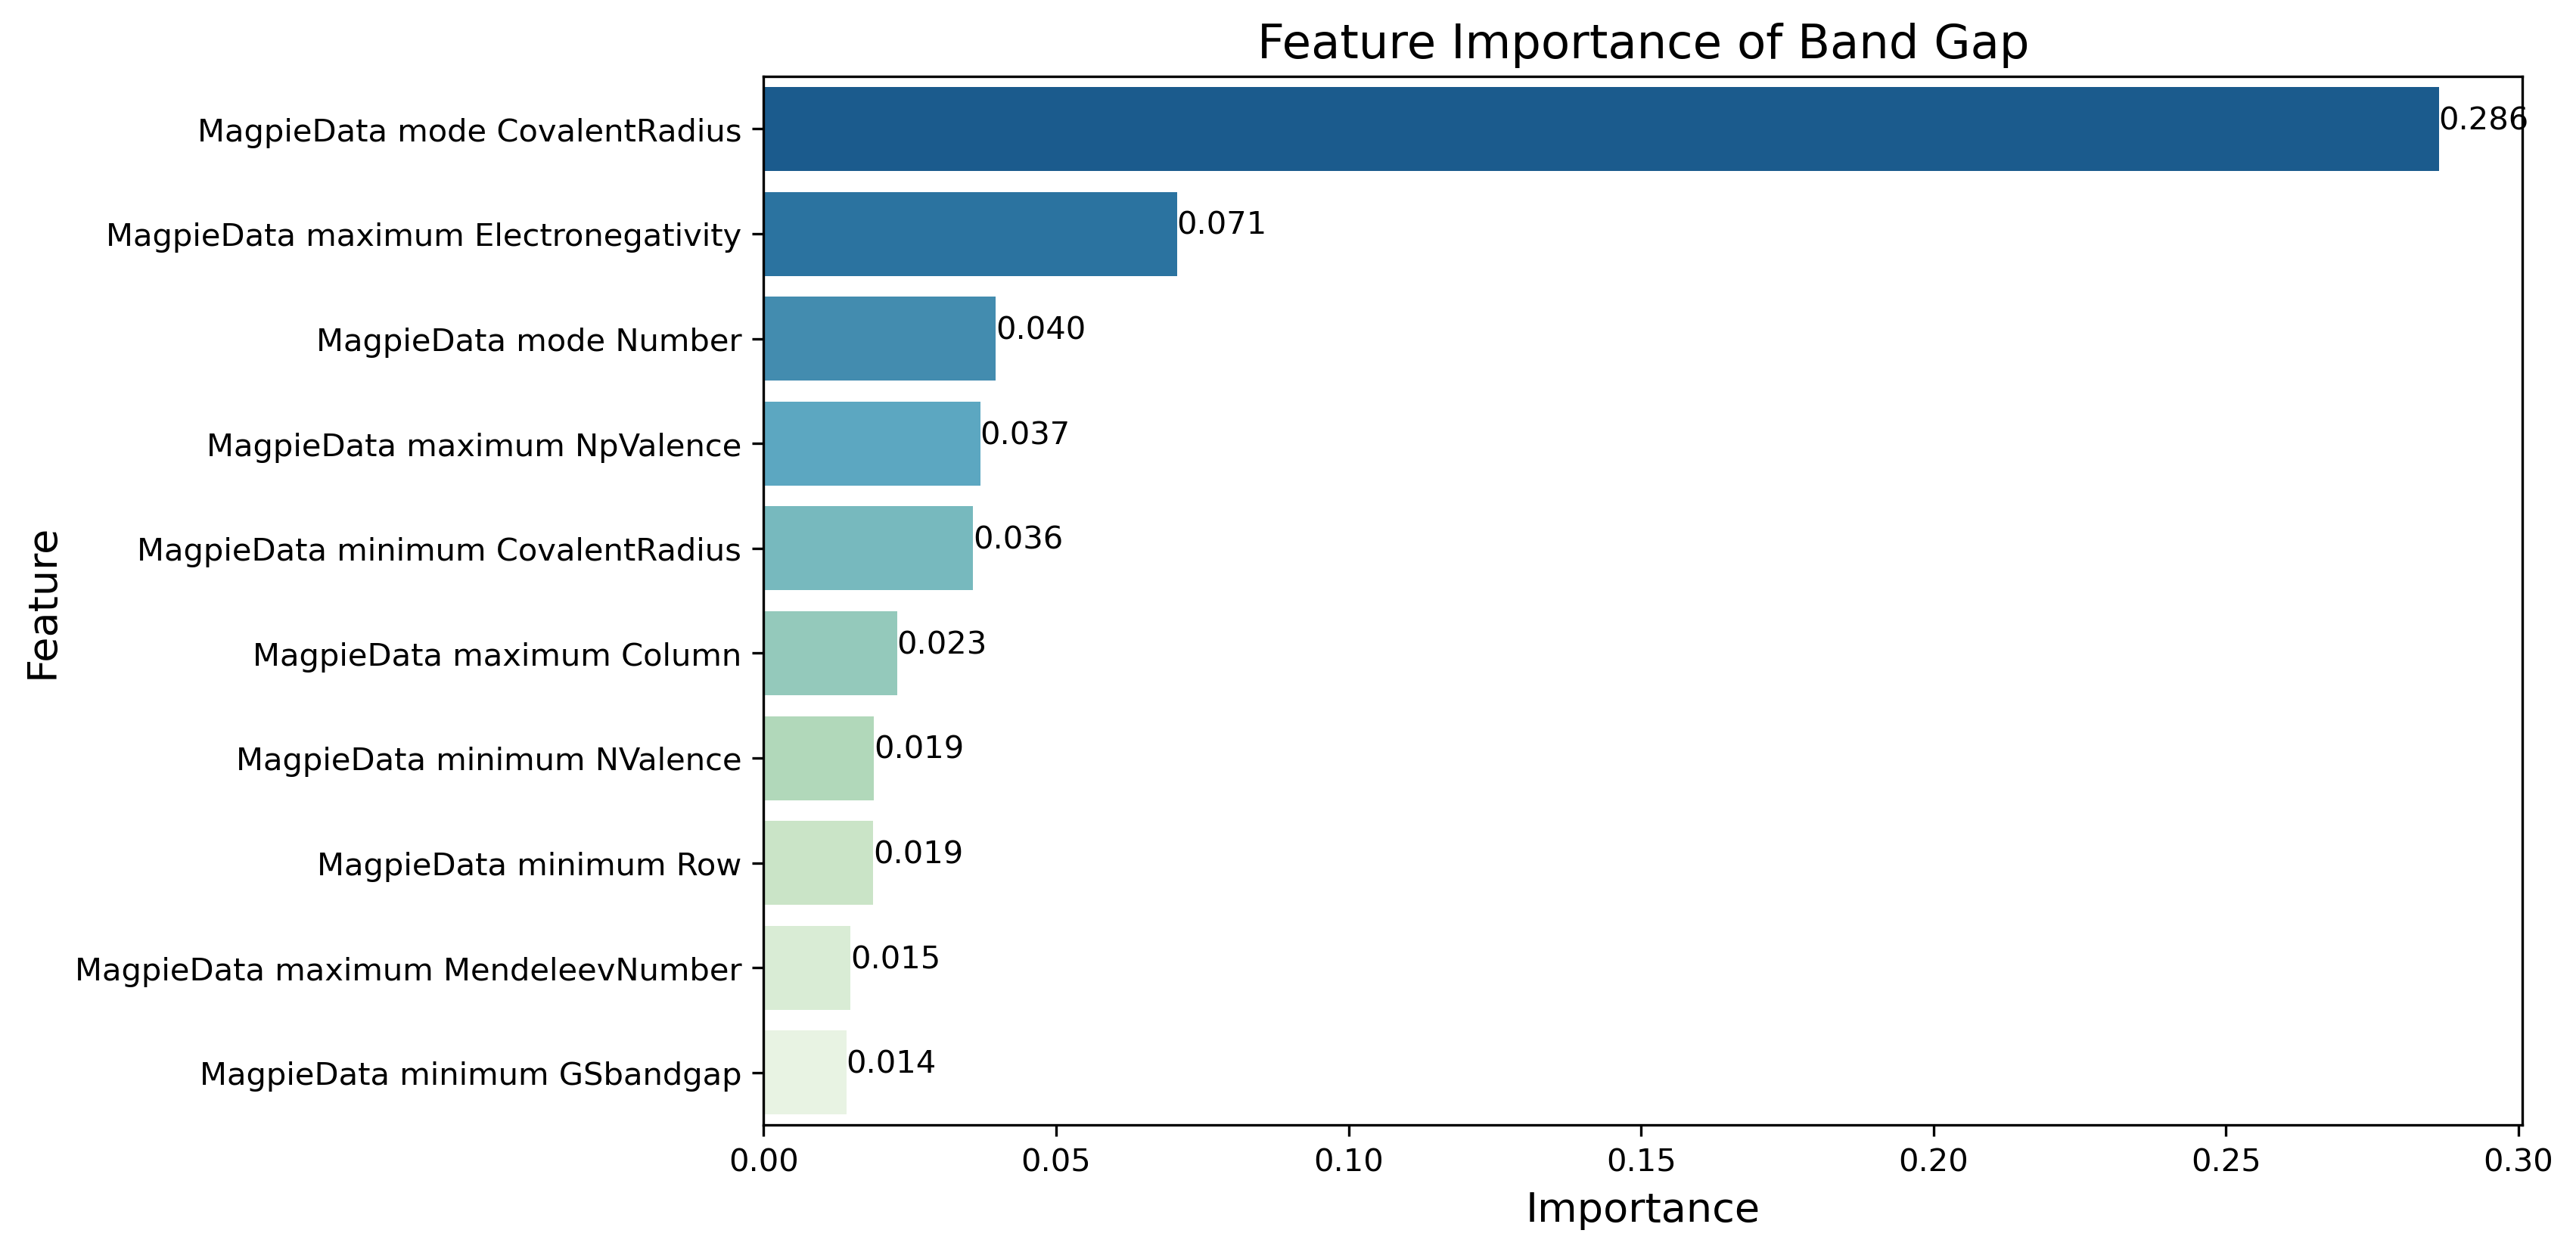

In [9]:
# 绘制特征重要性图
from Utools.draw import plot_feature_importance
importances_df = plot_feature_importance(dft_model.get_model(), dft_train_X.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'feature_importance.png'))  

In [10]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,Train,dft,dft,0.998477,0.032984,0.023905
1,XGBoost,Test,dft,dft,0.666303,0.491803,0.349274


In [11]:
# Save the model metrics to a CSV file
model_metrics.to_csv(os.path.join('./metrics', 'mp_plus_metrics.csv'), index=False)

## 误差分析

In [ ]:
y_pred = dft_model.predict(dft_test_X)
y_pred

array([1.0421067 , 2.2322748 , 1.5621752 , ..., 0.95838195, 2.1873333 ,
       1.976418  ], shape=(1108,), dtype=float32)

In [13]:
dft_test['y_pred'] = y_pred
dft_test.head()

,composition,nsites,crystal_system,space_group,volume,density,density_atomic,efermi,energy_per_atom,formation_energy_per_atom,...,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,y_pred
0,Ag4C2O6,12,4,11,150.041421,6.103459,12.503452,1.709619,-6.049623,-1.089885,...,0.0,0.0,0.0,12.0,225.0,213.0,113.333333,101.333333,12.0,1.042107
1,Ag12Ge6S36O126,180,6,147,2544.837686,3.197654,14.137987,0.457826,-6.234630,-1.599755,...,0.0,0.0,0.0,12.0,225.0,213.0,44.900000,46.060000,12.0,2.232275
2,Ag6P3H3O12,24,6,151,310.718968,4.997597,12.946624,1.408234,-5.859486,-1.573441,...,0.0,0.0,0.0,2.0,225.0,223.0,86.750000,95.937500,12.0,1.562175
3,Ag8Se4O12,24,4,14,379.079939,6.004620,15.794997,1.411950,-4.829366,-0.825087,...,0.0,0.0,0.0,12.0,225.0,213.0,83.333333,94.444444,12.0,0.405472
4,Ag8Se4O12,24,4,14,347.441675,6.551405,14.476736,5.866702,-13.060735,-0.572339,...,0.0,0.0,0.0,12.0,225.0,213.0,83.333333,94.444444,12.0,0.218774


In [16]:
dft_test['error'] = np.abs(dft_test['y_pred'] - dft_test['band_gap'])
dft_test['error'].describe()

count    1108.000000
mean        0.349274
std         0.346391
min         0.000009
25%         0.099828
50%         0.242603
75%         0.481864
max         2.585972
Name: error, dtype: float64

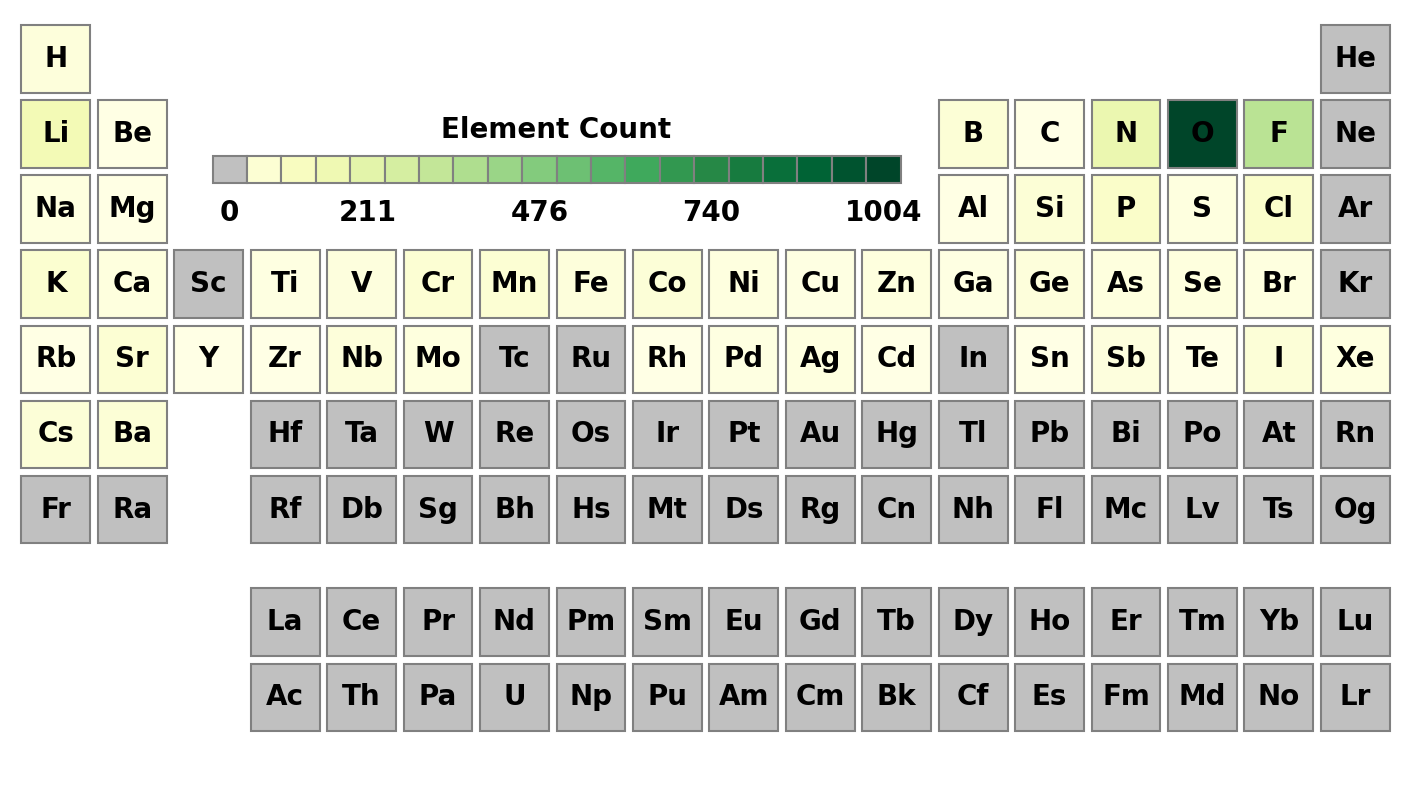

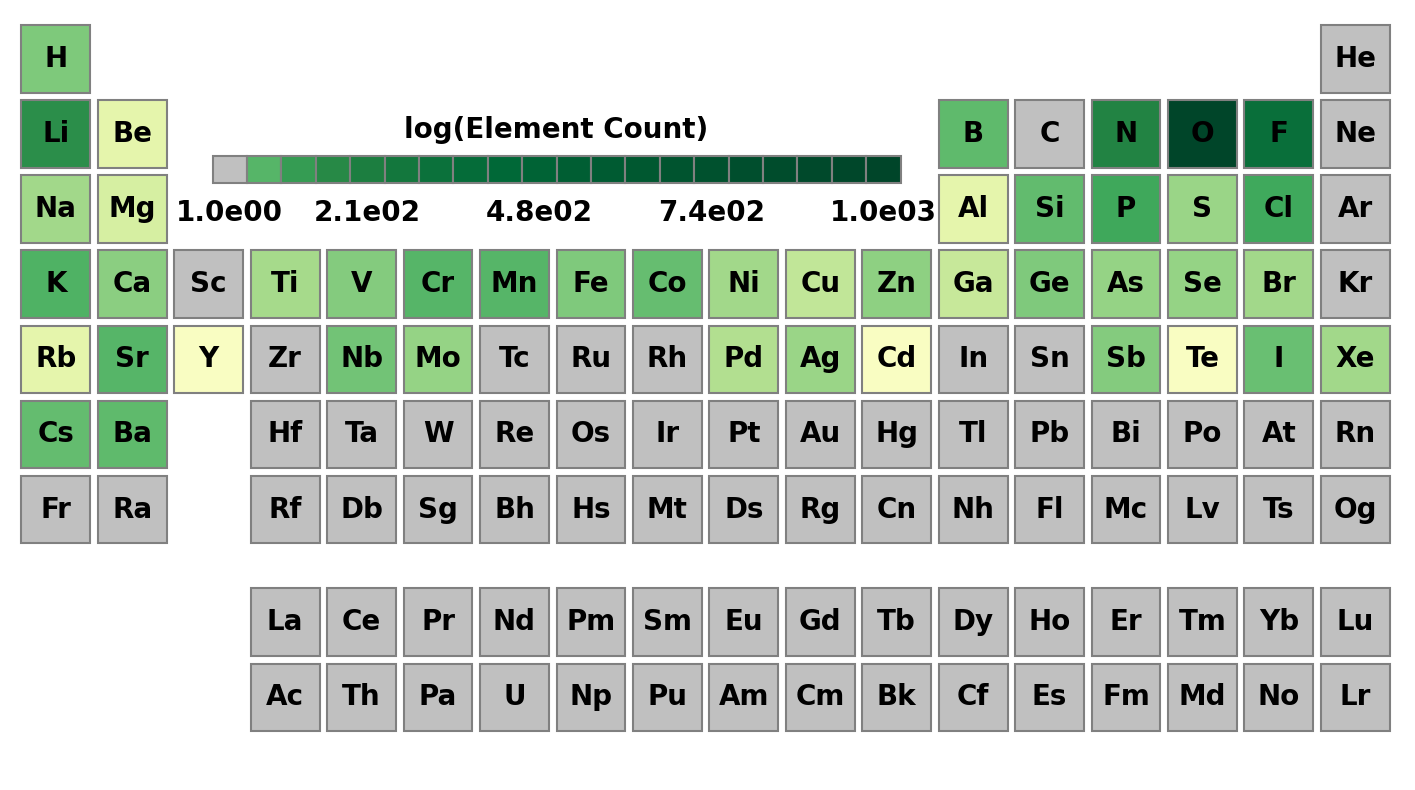

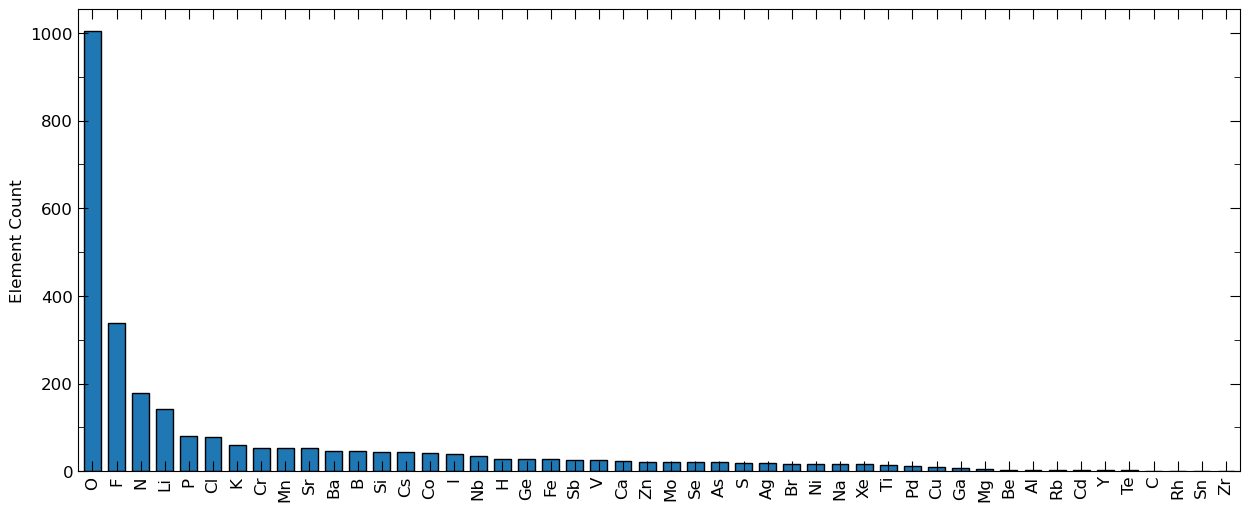

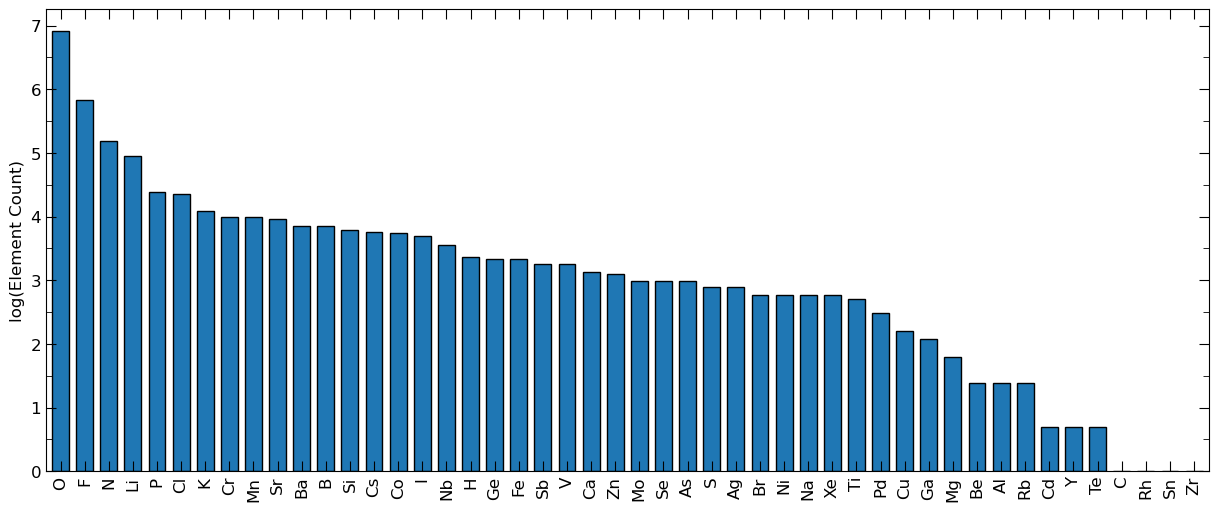

In [27]:
# 误差大于1eV的元素分布
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = dft_test[dft_test['error'] > 1.0].copy()
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df['composition']
save_dir = os.path.join(fig_path, 'error_greater_than_1eV_elements_distribution')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory

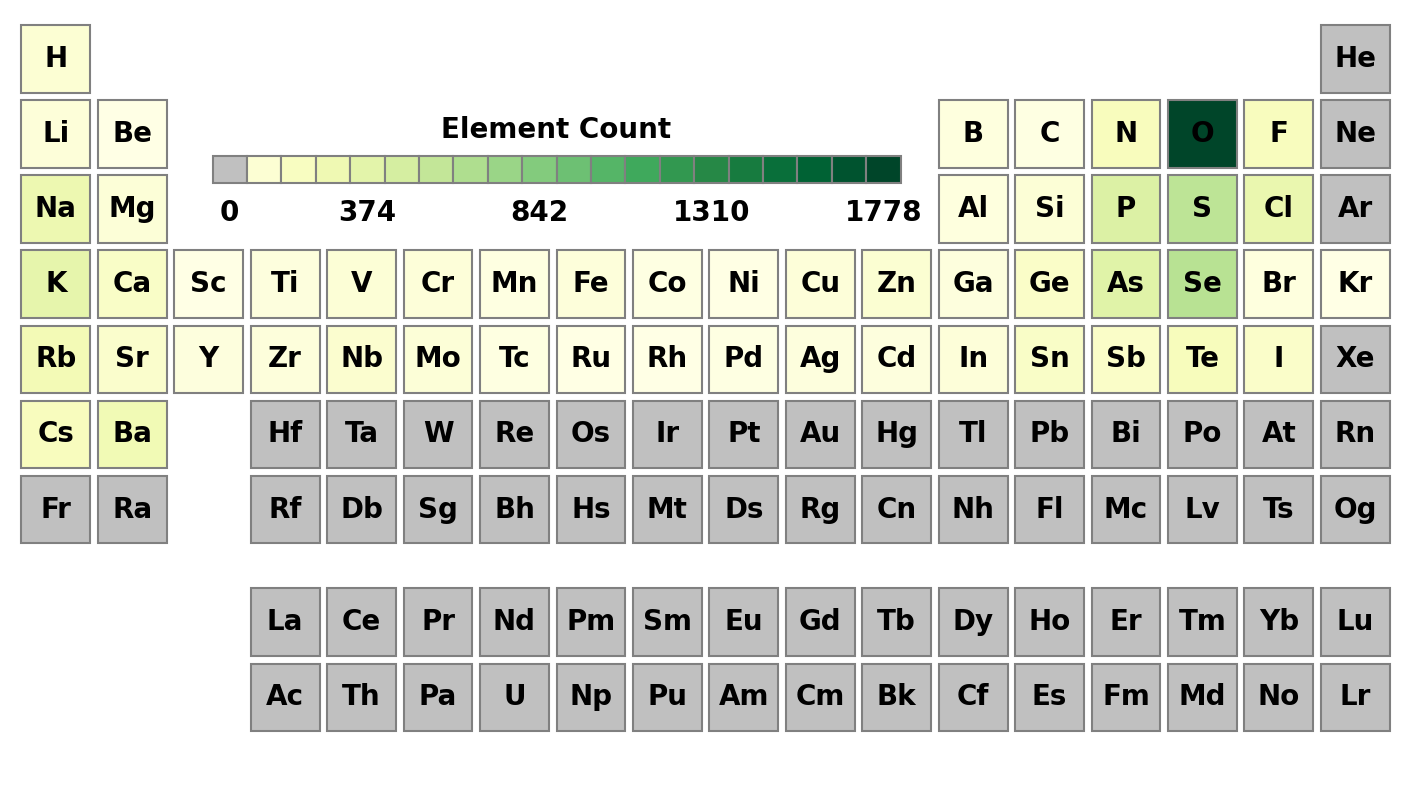

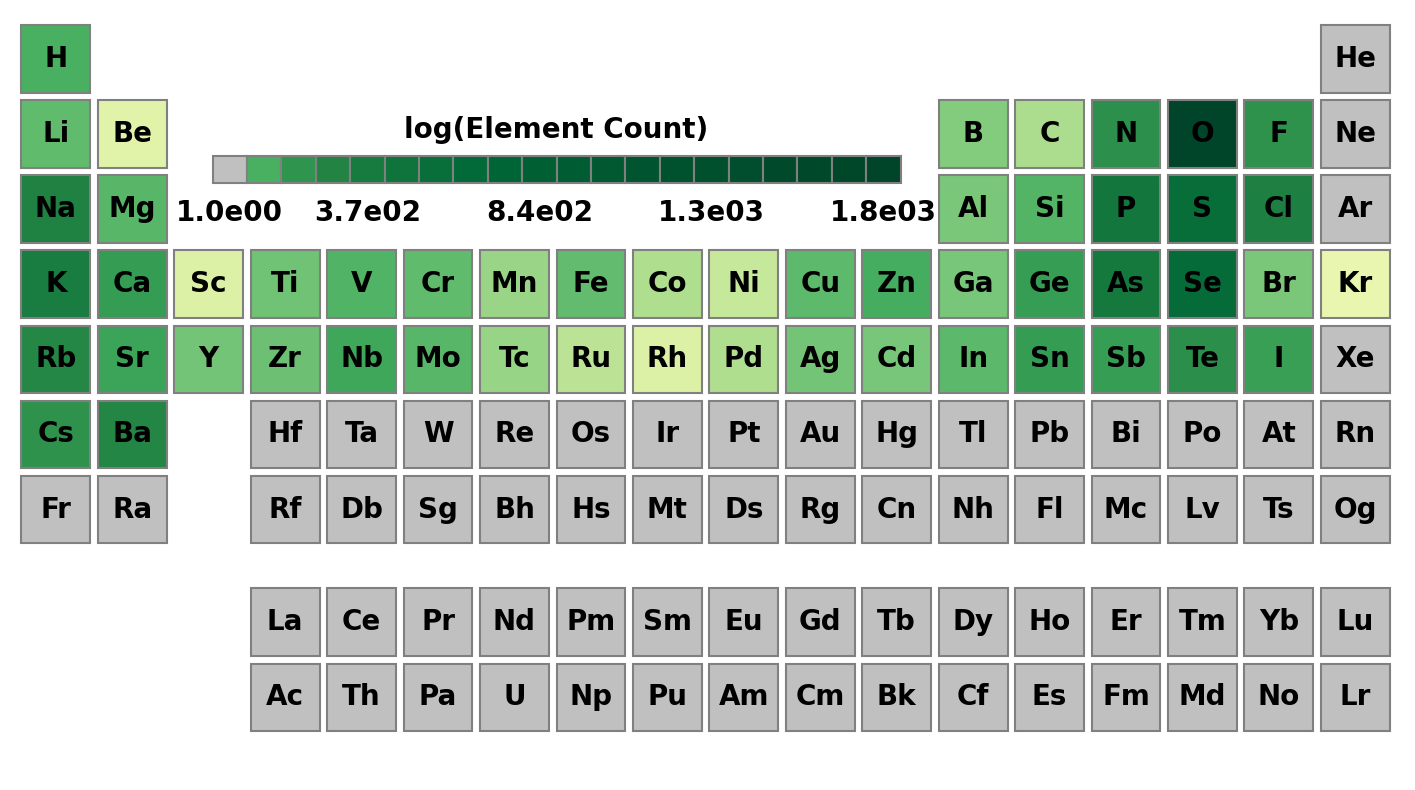

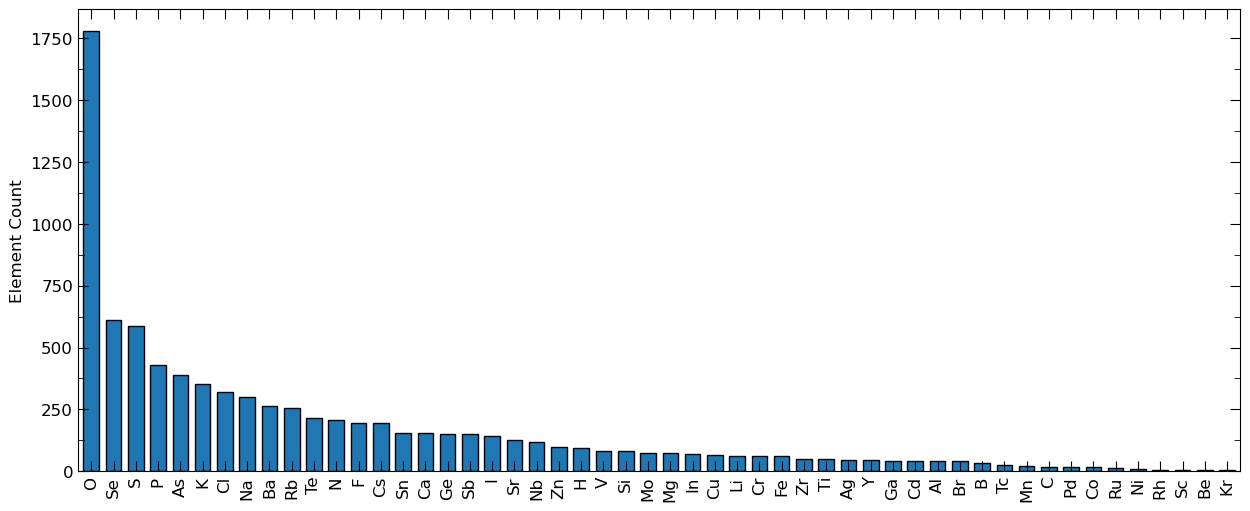

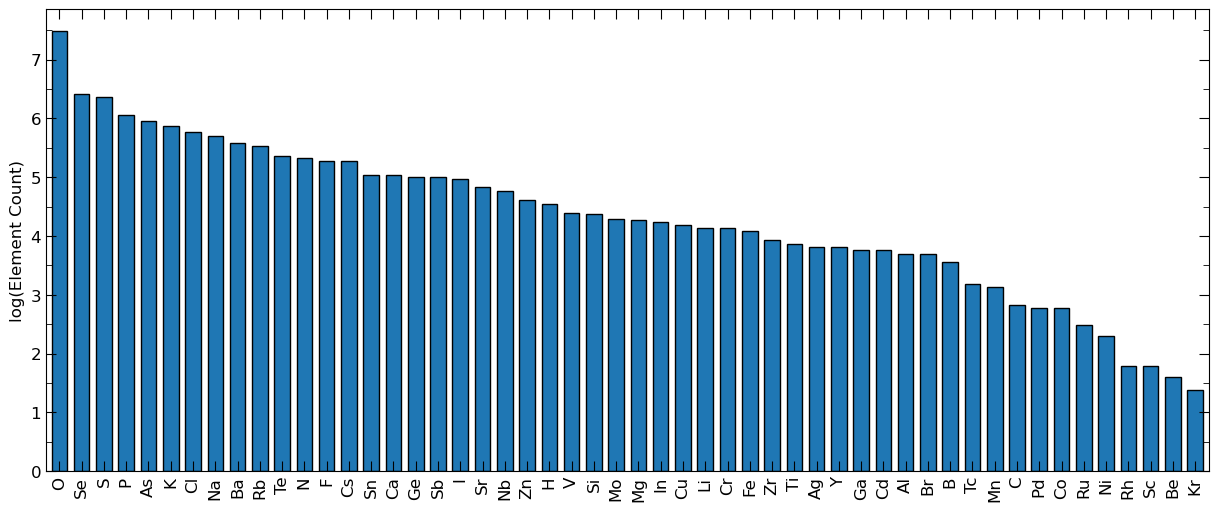

In [18]:
# 误差小于0.1eV的元素分布
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = dft_test[dft_test['error'] < 0.1].copy()
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df['composition']
save_dir = os.path.join(fig_path, 'error_less_than_0.1eV_elements_distribution')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory